## warehouse collision 해결하고 warehouse에 코드로 넣기

### deadend 해결을 heuristic map으로 구현한다면, navigate 설정을 조금 바꿔야 함 (어렵지 않음)

In [1]:
import os
import numpy as np
from crewai import Agent, Task, Crew
from environment import Environment
from openai import OpenAI
import copy
import configs
import pickle

os.environ["OPENAI_API_KEY"] = ""
client = OpenAI()

In [2]:
#negotiator를 구성하기 위한 union find 알고리즘

def find(parent, i):
    if parent[i] == i:
        return i
    else:
        return find(parent, parent[i])

def union(parent, rank, x, y):
    xroot = find(parent, x)
    yroot = find(parent, y)

    if xroot != yroot:
        if rank[xroot] < rank[yroot]:
            parent[xroot] = yroot
        elif rank[xroot] > rank[yroot]:
            parent[yroot] = xroot
        else:
            parent[yroot] = xroot
            rank[xroot] += 1

def merge_sets(lists):
    element_to_index = {}
    for i, subset in enumerate(lists):
        for element in subset:
            element_to_index[element] = i

    parent = [i for i in range(len(lists))]
    rank = [0] * len(lists)

    for subset in lists:
        first_element = subset[0]
        for element in subset[1:]:
            union(parent, rank, find(parent, element_to_index[first_element]), find(parent, element_to_index[element]))

    new_sets = {}
    for element in element_to_index:
        root = find(parent, element_to_index[element])
        if root not in new_sets:
            new_sets[root] = set()
        new_sets[root].add(element)

    return [list(s) for s in new_sets.values()]

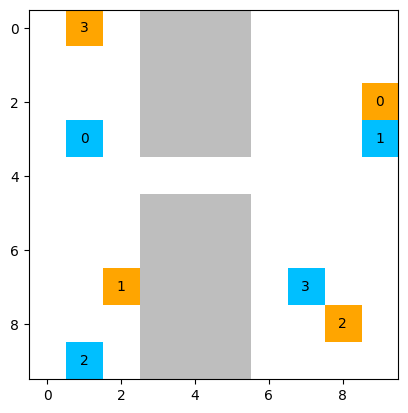

In [3]:
directiondict = {
    'Stay': 0, 'North': 1, 'South': 2, 'West': 3, 'East': 4, 'Stay.': 0, 'North.': 1, 'South.': 2, 'West.': 3, 'East.': 4 
}

# Toy example 만들기(환경, 처음 위치, 목적지)
toy = (np.array([[0, 0, 0, 1, 1, 1, 0, 0, 0, 0], [0, 0, 0, 1, 1, 1, 0, 0, 0, 0], [0, 0, 0, 1, 1, 1, 0, 0, 0, 0], [0, 0, 0, 1, 1, 1, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 1, 1, 1, 0, 0, 0, 0], [0, 0, 0, 1, 1, 1, 0, 0, 0, 0], [0, 0, 0, 1, 1, 1, 0, 0, 0, 0], [0, 0, 0, 1, 1, 1, 0, 0, 0, 0], [0, 0, 0, 1, 1, 1, 0, 0, 0, 0]]), np.array([[3, 1], [3, 9], [9, 1], [7, 7]]), np.array([[2, 9], [7, 2], [8, 8], [0, 1]]))
num_agents = len(toy[1])
map_width = len(toy[0][0]) - 1

env = Environment()
env.load(toy[0], toy[1], toy[2])
env.render()

In [4]:
class PathFindingAgents:
  def path_finder(self, agent_number):
    return Agent(
      role='Path finder',
      goal='Start at the start point and reach the end point without crashing into a wall.',
      backstory=f"""You are a veteran adventurer with a great sense of direction.
      You understand which direction you need to move to get from where you are to where you want to go.
      Your agent number is {agent_number}.
      """,
      verbose=True
    )
    
  def negotiator(self):
    return Agent(
      role='Negotiator',
      goal="""Determine whether the deadlocked agents would collide with each other if they took their original planned moves, and if so, stop all but the agent with the largest number.""",
      backstory="""You're a veteran overseer, and you've been called in to resolve the deadlock, as each agent is in the other's line of sight.
      """,
      verbose=True,
    )
	
class PathFindingTasks():
  def path_finding(self, agent, x, y, x_finish, y_finish, east, west, north, south, last_action):
    return Task(
      description=(
        f"""
        Your current coordinates are ({x},{y}) and your destination is ({x_finish},{y_finish}).
        East and west in the coordinates correspond to the x axis.
        South and north in the coordinates correspond to the y axis.
        You can only move east, west, south and north or stay.
        So, your answer will be {{East}}, {{West}}, {{South}}, {{North}}, or {{Stay}}.
        You can only make one move at a time.
        {east}
        {west}
        {south}
        {north}
        Which direction do you move next?
        {last_action}
        Answer in one word only: {{DIRECTION or ACTION}}
        """
      ),
      expected_output='Direction or action',
      agent=agent
    )
    
  def negotiate(self, agent):
    return Task(
      description=(
        f"""
        Determine whether the deadlocked agents would collide with each other if they took their original planned moves, and if so, stop all but the agent with the largest number.
        The planned moves of each agent represent the previous outcomes.
        """
      ),
      expected_output='Direction of the agents',
      agent=agent
    )
  
  def give_way(self, agent, east, west, north, south, direction):
    return Task(
      description=(
        f"""
        You MUST avoid collisions with prior path finder.
        You can only move east, west, south and north or stay.
        So, your answer will be {{East}}, {{West}}, {{South}}, {{North}}, or {{Stay}}.
        You can only make one move at a time.
        {east}
        {west}
        {south}
        {north}
        To the {direction} of you is prior path finder.
        Which direction do you move next?
        I highly recommend going to the 90-degree turn rather than the other side of the pathfinder, but you can ignore this instruction depending on your situation.
        Answer in one word only: {{DIRECTION or ACTION}}
        """
      ),
      expected_output='Direction or action',
      agent=agent
    )

agents = PathFindingAgents()
tasks = PathFindingTasks()

agents_set = [agents.path_finder(i) for i in range(num_agents)]
negotiator = agents.negotiator()

In [5]:
#에이전트들의 지난번 액션들과 좌표
action_list = [[] for _ in range(num_agents)]



> Entering new CrewAgentExecutor chain...


2024-06-18 14:37:37,050 - 20764 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed


Since my current coordinates are (1,6) and my destination is (9,7), I need to move eastward to increase my x-coordinate and slightly northward to increase my y-coordinate. Therefore, my next move should be towards the east.

Final Answer: East.

> Finished chain.


> Entering new CrewAgentExecutor chain...


2024-06-18 14:37:43,050 - 20764 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed


Considering my current position is (9,6) and my destination is (2,2), I need to move towards the west and the south to reach my target location. Checking the paths around me, I can move in any direction. However, the optimal choice will be to first move towards the west to decrease the distance on the x-axis. 

Final Answer: West

> Finished chain.


> Entering new CrewAgentExecutor chain...


2024-06-18 14:37:45,174 - 20764 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed


Considering the current position and the destination, the best move would be to head towards the east which gets me closer to the goal.

Final Answer: East

> Finished chain.


> Entering new CrewAgentExecutor chain...
Looking at the current coordinates and the destination, it seems I am currently to the east and south of my destination. So, I need to move west and north to reach the destination. Since I have paths available in all directions, I can choose to move either west or north. However, since the distance to cover in the y-axis (north-south) is greater than the x-axis (east-west), it might be wiser to start moving north first.

Final Answer: North

> Finished chain.


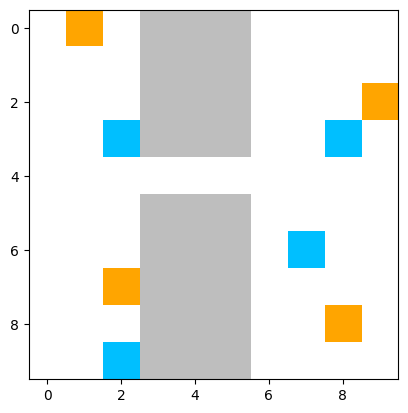

2024-06-18 14:37:50,863 - 20764 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed




> Entering new CrewAgentExecutor chain...


2024-06-18 14:37:55,431 - 20764 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed


Given my current position and the destination, I need to move towards the right on the x-axis and slightly up on the y-axis. However, since my path towards the east is blocked by a wall, I can't move in the direct path. Considering I came from the west, and going back isn't a good option, I have two possibilities remaining: moving north or moving south. 

Final Answer: North

> Finished chain.


> Entering new CrewAgentExecutor chain...


2024-06-18 14:38:00,475 - 20764 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed


To move from my current position (8,6) to the destination (2,2), I need to move west and south. Since I just came from the east, moving back east would lead me away from the destination. North would also lead me away from the destination. So, the options are west and south. I can choose either, but to minimize the total distance traveled, I should first move in the direction that has the most distance to cover. That is along the x-axis, by moving west.

Final Answer: West.

> Finished chain.


> Entering new CrewAgentExecutor chain...


2024-06-18 14:38:04,769 - 20764 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed


Since I cannot move east due to the wall and coming from the west, it would not be logical to go back. Therefore, the best logical direction would be to go either north or south. Since there is no further information given about what lies north or south, I will choose to go north as it is closer to the y coordinate of the destination.

Final Answer: North

> Finished chain.


> Entering new CrewAgentExecutor chain...
Considering my current position (7,3) and my destination (1,9), I need to move North and West. Since I just came from the South, moving North would be a logical choice to avoid doubling back. 

Final Answer: North

> Finished chain.


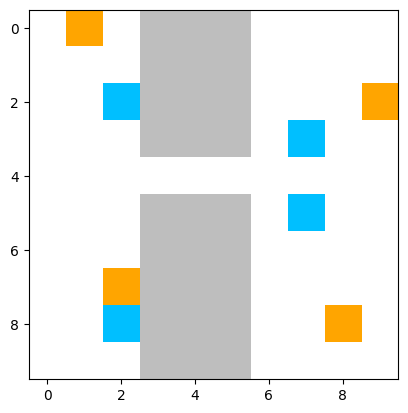

2024-06-18 14:38:08,059 - 20764 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed




> Entering new CrewAgentExecutor chain...


2024-06-18 14:38:12,708 - 20764 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed


Since my destination is (9,7) and I'm currently at (2,7), I need to move east to increase my x-coordinate. However, the east is blocked by a wall. The only available paths are to the west, south, and north. Moving west would take me further away from my destination. Since I came from south, it's not logical to go back. Therefore, I should move north hoping to find another path heading east.

Final Answer: North

> Finished chain.


> Entering new CrewAgentExecutor chain...


2024-06-18 14:38:16,607 - 20764 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed


Since my current coordinates are (2,1) and my destination is (8,1) and the east is blocked by a wall, I should take a different path to eventually reach an area where I can move east. Since I just came from the south, I can either go north or back to the west. Going west would move me further away from the destination, so my best option is to move north.

Final Answer: North

> Finished chain.


> Entering new CrewAgentExecutor chain...


2024-06-18 14:38:19,886 - 20764 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed


I need to get from (7,6) to (2,2). Looking at the coordinates, it's clear that I need to move west and south. Since I just came from the east, it would be most efficient to start moving west first. 

Final Answer: West

> Finished chain.


> Entering new CrewAgentExecutor chain...
I need to get to the point (1,9) from my current location (7,4). This means I need to move west in the x direction and north in the y direction, as the destination point has lower x-value and higher y-value than the current point. Considering there is a path in every direction, I need to decide which direction to move first. Since I came from the south, I need to avoid going back that way. Hence, I should move North or West. It would be more logical to start moving towards North as the y-coordinate difference (9-4=5) is higher than the x-coordinate difference (7-1=6). 

Final Answer: North.

> Finished chain.


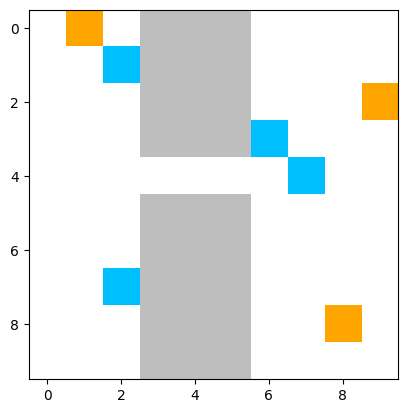

2024-06-18 14:38:26,888 - 20764 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed




> Entering new CrewAgentExecutor chain...


2024-06-18 14:38:32,250 - 20764 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed


Considering my current coordinates are (2,8), and my destination is (9,7), I am currently closer to the destination in terms of the y-axis, but further on the x-axis. Going east is not an option as it's blocked by a wall. Since I came from the south, going back there would be counterproductive. Therefore, the logical direction to take would be North or West. However, since I need to move towards increasing x values to reach my destination, going west would be more beneficial.

Final Answer: West

> Finished chain.


> Entering new CrewAgentExecutor chain...


2024-06-18 14:38:39,960 - 20764 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed


Given my current coordinates are (2,2) and my goal is to reach (8,1), it's clear that I need to move in the east direction. However, my path to the east is blocked by a wall. Therefore, I need to find an alternate route. I have come from the South, so it won't be productive to move back. I can either go North or West. As moving West would take me further away from my goal, I should not take that route. Therefore, the best option seems to be to move North to potentially find a path that leads me East towards my destination.

Final Answer: North

> Finished chain.


> Entering new CrewAgentExecutor chain...


2024-06-18 14:38:43,102 - 20764 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed


Considering the current coordinates (6,6) and the destination (2,2), it is clear that I need to move both west and south. However, since west is blocked, the only logical move would be to go south. This will bring me closer to my destination on the y-axis.

Final Answer: South

> Finished chain.


> Entering new CrewAgentExecutor chain...


2024-06-18 14:38:50,391 - 20764 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed


Considering I am currently at (7,5) and my destination is at (1,9), I need to move in the direction that brings me closer to this destination. As the y-coordinate of my destination is greater than my current y-coordinate, moving north would bring me closer. Also, since the x-coordinate of my destination is less than my current x-coordinate, moving west would also bring me closer. However, since I just came from the south, moving north would mean retracing my steps. Therefore, it would be more efficient to move west.

Final Answer: West

> Finished chain.


> Entering new CrewAgentExecutor chain...
Considering the current situation and the recommendation provided, I should avoid the southeast direction, where the prior pathfinder is located. As my west is blocked by a wall and the south could potentially lead me closer to the other pathfinder, it seems the best options are either to move north or east. Since the task does not specify any particular end point, both directions seem equall

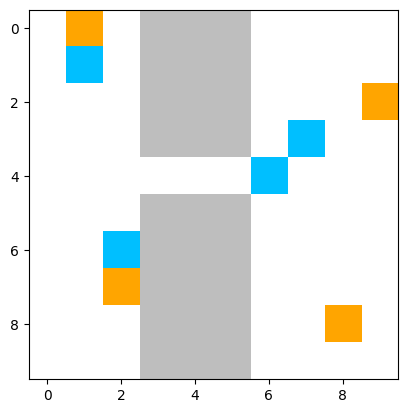

2024-06-18 14:38:57,511 - 20764 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed




> Entering new CrewAgentExecutor chain...


2024-06-18 14:39:03,959 - 20764 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed


Considering my current location (1,8) and my desired destination (9,7), I need to move towards the east to increase my x-coordinate and towards the south to decrease my y-coordinate. Since I can only make one move at a time and I came from the east, it would be more logical to move either south or east to avoid backtracking. As both directions are open to me, either choice could be viable, but I'll choose to prioritize moving east to quickly increase my x-coordinate.

Final Answer: East

> Finished chain.


> Entering new CrewAgentExecutor chain...


2024-06-18 14:39:07,800 - 20764 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed


Given my current coordinates (2,3), I need to reach (8,1). Since I can't move east due to a wall and I came from the south, my best option is to move either north or west. Moving north will take me away from my goal on the y-axis, so I should move west to make progress.

Final Answer: West

> Finished chain.


> Entering new CrewAgentExecutor chain...


2024-06-18 14:39:10,562 - 20764 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed


Considering the current coordinates and the destination, it is clear that I need to move towards the west and towards the south to reach the destination. Since I can only make one move at a time, I will choose one direction to move first. 

Final Answer: West

> Finished chain.


> Entering new CrewAgentExecutor chain...


2024-06-18 14:39:15,525 - 20764 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed


To reach my destination from (6,5) to (1,9), I need to move west to decrease the x coordinate and north to increase the y coordinate. Since I came from the east, it would be better to move in a different direction to avoid possible backtracking. Therefore, moving north seems to be the most logical next step.

Final Answer: North

> Finished chain.


> Entering new CrewAgentExecutor chain...
Considering all the paths available to me and the location of the prior pathfinder, it would be safer to make a 90-degree turn, as recommended. The prior pathfinder is to my southwest, so I should avoid going south or west. Hence, I should either move east or north. 

Final Answer: East

> Finished chain.


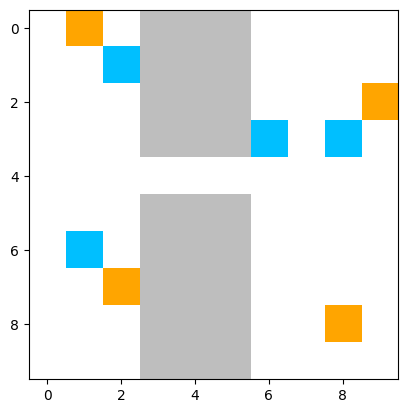

2024-06-18 14:39:19,959 - 20764 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed




> Entering new CrewAgentExecutor chain...


2024-06-18 14:39:26,125 - 20764 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed


Considering my current position (2,8) and my destination (9,7), I need to move towards the east to reach the destination. However, the east is blocked by a wall. Since I came from the west, moving back that way might not be the best option. Thus, the logical move would be either north or south. Since there's no indication of any barriers in these directions, I'll choose to move south, which will possibly give me an opportunity to move east in the next step.

Final Answer: South

> Finished chain.


> Entering new CrewAgentExecutor chain...


2024-06-18 14:39:29,306 - 20764 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed


Looking at my current location, (1,3), I need to move to the east to increase my x-coordinate and approach the destination, (8,1). I came from the East, so there's a path open there. 

Final Answer: East.

> Finished chain.


> Entering new CrewAgentExecutor chain...


2024-06-18 14:39:32,158 - 20764 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed


Considering my current coordinates are (8,6) and my target destination is (2,2), I need to move west and south to reach the destination. Since there are paths in all directions, I can choose to move in either direction first. 

Final Answer: West

> Finished chain.


> Entering new CrewAgentExecutor chain...
Considering my current coordinates are (6,6) and my destination is at (1,9), I need to move towards the north to increase the y-coordinate and towards the west to decrease the x-coordinate. However, the west is blocked, thus I should proceed north since it's open. Also, as I came from the south, moving north will prevent me from going back in the same direction.

Final Answer: North

> Finished chain.


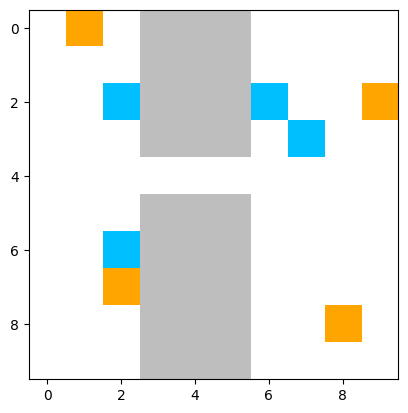

2024-06-18 14:39:37,501 - 20764 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed




> Entering new CrewAgentExecutor chain...


2024-06-18 14:39:42,308 - 20764 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed


Considering my current position (2,7) and my goal (9,7), I need to move towards the east to reach my destination. However, the east is currently blocked by a wall. My options then are to move west, south or north. Since I just came from the north, it wouldn't be logical to go back in that direction. So, I am left with either west or south. Since there is no additional information about the layout of the terrain, I will choose the south direction as it may lead me to a path that goes east.

Final Answer: South

> Finished chain.


> Entering new CrewAgentExecutor chain...


2024-06-18 14:39:46,227 - 20764 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed


Considering my current position and the destination, moving south or north won't help me reach the destination faster because it will increase the distance from the destination. Since moving east is blocked by a wall and I came from the west, the best option left for me is to remain where I am and wait for further instructions or until the path to the east is clear.

Final Answer: Stay.

> Finished chain.


> Entering new CrewAgentExecutor chain...


2024-06-18 14:39:48,955 - 20764 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed


Based on my current location (7,6) and destination (2,2), I need to move west and south. Since I came from east, it would be more efficient to move towards south first to avoid going back.

Final Answer: South

> Finished chain.


> Entering new CrewAgentExecutor chain...
Considering that my current position is (6,7) and my destination is (1,9), I need to move to the north to increase my y-coordinate and west to decrease my x-coordinate. Since I came from the south and my west is blocked by a wall, the most logical and safe move would be to go north where a path lies.
Final Answer: North.

> Finished chain.


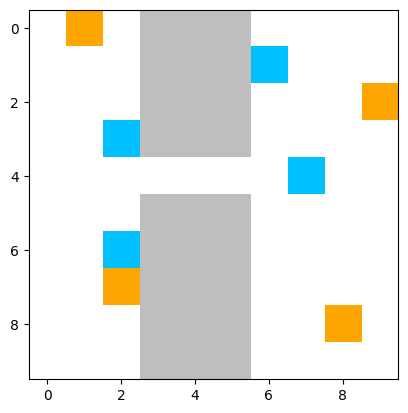

2024-06-18 14:39:53,462 - 20764 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed




> Entering new CrewAgentExecutor chain...


2024-06-18 14:39:58,517 - 20764 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed


Since I can't move east due to the wall, and I shouldn't move north since that's where I came from, I have two options left - west and south. However, to reach my destination (9,7) from my current position (2,6), I have to increase my x-coordinate and keep my y-coordinate steady or increase it. Thus, moving south is not a rational option. Therefore, I should move west first and hopefully, there will be a path leading east afterwards.

Final Answer: West

> Finished chain.


> Entering new CrewAgentExecutor chain...


2024-06-18 14:40:03,429 - 20764 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed


In order to reach the destination, I need to move towards lower coordinates from my current position. As I am at (7,5), and my destination is (2,2), I need to move west and south. As I can only make one move at a time, and since moving south would bring me closer to the y-coordinate of my destination, my next move should be towards the south.

Final Answer: South

> Finished chain.


> Entering new CrewAgentExecutor chain...


2024-06-18 14:40:07,919 - 20764 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed


Considering my current position (2,3), my goal is to reach (8,1). Since moving east is blocked by a wall, my only viable options are to move west, south, or north. Comparing my current position to my destination, I can see that I need to move mostly in the east direction, and a bit south. Moving west or north would take me further away from my goal. Hence, I should move south. 

Final Answer: South

> Finished chain.


> Entering new CrewAgentExecutor chain...
Considering my current position (6,8), my destination is at (1,9). The destination is to the west but that direction is blocked by a wall. Therefore, I need to find an alternate route. I can't go back south as it will take me further away from my destination. The path to the east might lead me around the wall and closer to my destination, hence that's my best option.

Final Answer: East

> Finished chain.


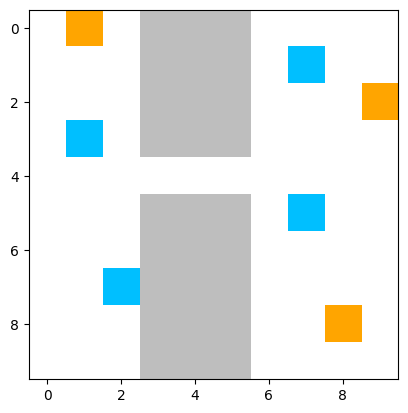

2024-06-18 14:40:12,560 - 20764 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed




> Entering new CrewAgentExecutor chain...


2024-06-18 14:40:16,141 - 20764 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed


Considering that I am currently at (1,6) and my destination is (9,7), it seems I need to move primarily in the east direction to increase my x-coordinate. Since I came from east, I should not go back west. Therefore, my next movement should be east.

Final Answer: East

> Finished chain.


> Entering new CrewAgentExecutor chain...


2024-06-18 14:40:19,057 - 20764 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed


Considering my current location and destination, I need to shift towards the west and south in order to reach my goal. Since I can only make one move at a time, I will first move west as it reduces the distance on the x axis. 

Final Answer: West

> Finished chain.


> Entering new CrewAgentExecutor chain...


2024-06-18 14:40:22,511 - 20764 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed


Considering my current position and the available paths, moving west or south would take me further away from my destination. Moving north would bring me back to my previous position. Hence, the best direction to move next would be staying in my current position and evaluate the situation to make further decisions.

Final Answer: Stay

> Finished chain.


> Entering new CrewAgentExecutor chain...
Considering the current position and the destination, I need to move towards (1,9) from (7,8). This means I have to move west in order to decrease the x-coordinate. Since I came from the west, there is already a path there, so I can continue in that direction.

Final Answer: West

> Finished chain.


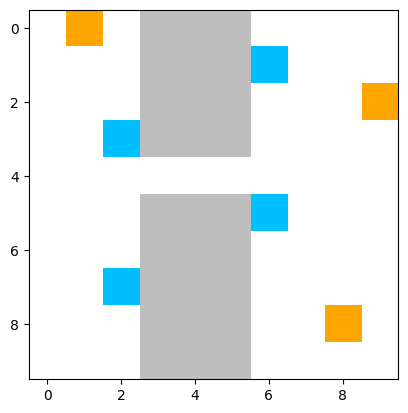

2024-06-18 14:40:26,928 - 20764 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed




> Entering new CrewAgentExecutor chain...


2024-06-18 14:40:33,039 - 20764 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed


Since I'm currently at (2,6) and my destination is (9,7), I need to move towards the East to increase my x-coordinate. However, the East is blocked by a wall. Since I also want to avoid going back from where I came (West), the best options left for me are either to go North or South. If I go North, I can potentially move around the obstacle to my East. If I go South, I might need to travel a longer path. Therefore, considering the current situation, I should move North.

Final Answer: North

> Finished chain.


> Entering new CrewAgentExecutor chain...


2024-06-18 14:40:36,246 - 20764 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed


Considering I am at (6,4) and my destination is at (2,2), I need to move towards the west and south. However, my west is blocked by a wall. Therefore, my only option to get closer to my destination is to move south.

Final Answer: South

> Finished chain.


> Entering new CrewAgentExecutor chain...


2024-06-18 14:40:40,034 - 20764 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed


Considering my current position (2,2) and my destination (8,1), I need to move towards the east to reach the x-coordinate of my destination. However, since the east is blocked by a wall, I need to find an alternative path. Looking at the available paths to the west, south, and north, it seems logical to choose south to move away from the wall and possibly find another route towards the east. 

Final Answer: South

> Finished chain.


> Entering new CrewAgentExecutor chain...
Based on my current position, the goal location, and the available paths, the best option would be to move North. This direction would bring me closer to the desired 'y' coordinate of the destination, which is 9. Moving East or South would take me further away from the target destination. Moving West is not an option because it's blocked by a wall. 

Final Answer: North

> Finished chain.


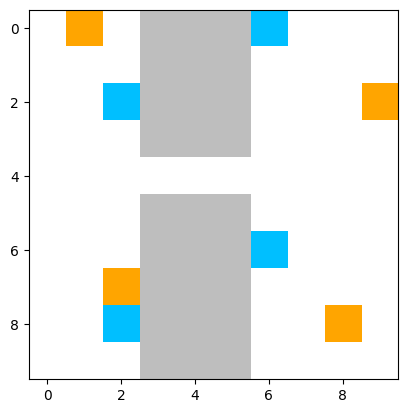

2024-06-18 14:40:45,271 - 20764 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed




> Entering new CrewAgentExecutor chain...


2024-06-18 14:40:51,792 - 20764 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed


Since my current coordinates are (2,7) and my destination is (9,7), I need to move east to reach my destination. However, the east is blocked by a wall. I can't move west because that would take me away from my destination. Since I came from the south, moving back in that direction would also not bring me closer to my destination. Therefore, the only logical direction to move next would be north, in the hope of finding a path that will allow me to continue east towards my destination.

Final Answer: North

> Finished chain.


> Entering new CrewAgentExecutor chain...


2024-06-18 14:40:55,309 - 20764 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed


Considering my current position is (6,3) and my goal is (2,2), I need to move towards the west and south. However, my immediate west is blocked by a wall. I can move either east, south, or north. Since I just came from the north and going east would take me farther from my destination, the best option left is to move south first.

Final Answer: South

> Finished chain.


> Entering new CrewAgentExecutor chain...


2024-06-18 14:40:58,292 - 20764 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed


Given my current position and the obstacle to the east, it seems the only logical move is to head west. Moving north would be retracing my steps and heading south would take me further away from my destination which lies in the same y-axis coordinates. So, going west seems to be the best step forward.

Final Answer: West

> Finished chain.


> Entering new CrewAgentExecutor chain...
Given my current position (6,9), the destination is (1,9), and the fact that I can only move east, west, south, and north or stay. My west is blocked by a wall. Therefore, to move closer to the destination, I should choose a direction that decreases my x-coordinate while keeping the y-coordinate the same. Considering my current position and the destination, it seems the best option would be to head west. However, my west is blocked. The only other directions available are east, north, and south. Given that I came from the south, I can either go east or north. Going east will increase my x-coordinate, taking

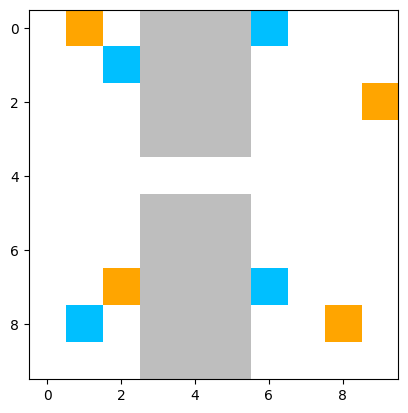

2024-06-18 14:41:04,908 - 20764 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed




> Entering new CrewAgentExecutor chain...


2024-06-18 14:41:09,292 - 20764 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed


Based on my current location and considering the conditions given, I should not go east because it is blocked by a wall. I should not go south as well since I just came from there. So, the best options left are either to go west or north. However, to reach my destination (9, 7) from my current position (2, 8), it would be more reasonable to go north as this would reduce the distance in the y-axis. 

Final Answer: North

> Finished chain.


> Entering new CrewAgentExecutor chain...


2024-06-18 14:41:11,527 - 20764 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed


Considering the current location, the destination, and the surrounding conditions, the best decision would be to head towards the target location by choosing the most direct path available. 

Final Answer: West

> Finished chain.


> Entering new CrewAgentExecutor chain...


2024-06-18 14:41:14,142 - 20764 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed


Since my current coordinates are (1,1) and my target is (8,1) on the x-axis, and I came from East, I need to keep moving East to reach my destination.

Final Answer: East.

> Finished chain.


> Entering new CrewAgentExecutor chain...
Since my current position is (6,9) and my goal is to reach (1,9), I need to move towards the west. However, the west is blocked by a wall. I can't move east because it will take me further away from my destination. I can't go south because I came from there. So, the best choice is to go North to potentially find a path that leads west.

Final Answer: North.

> Finished chain.


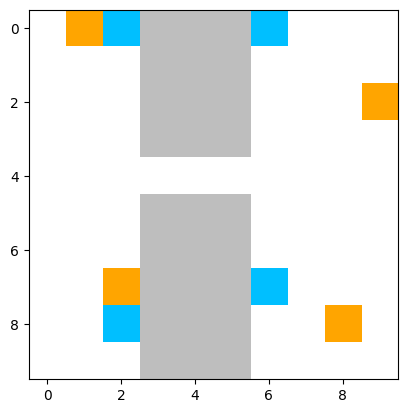

2024-06-18 14:41:19,465 - 20764 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed




> Entering new CrewAgentExecutor chain...


2024-06-18 14:41:24,527 - 20764 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed


Since my current position is (2,9) and my goal is to reach (9,7), I need to increase the x-coordinate to reach closer to the destination. However, the east is blocked by a wall. Therefore, the best move would be to go south or north to avoid the wall and find a new path that may lead me towards the east. Since I came from the south, it's more logical to go north to explore new areas instead of going back.

Final Answer: North.

> Finished chain.


> Entering new CrewAgentExecutor chain...


2024-06-18 14:41:28,381 - 20764 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed


Since my current location is (6,2) and my destination is (2,2), I need to move towards the west. However, west is blocked by a wall. To circumvent this, I'll need to move north or south first, then head west when possible. Given that I just came from the east, I'll choose to move north to avoid potentially going in circles. 

Final Answer: North

> Finished chain.


> Entering new CrewAgentExecutor chain...


2024-06-18 14:41:32,186 - 20764 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed


Based on my current position, the destination coordinates, and the available paths, it seems the best course of action would be to move towards the destination. Since the destination is to the east and east is blocked, I must find an alternative route. I've come from the west, so the logical course of action would be to move either north or south. 

Final Answer: North

> Finished chain.


> Entering new CrewAgentExecutor chain...
Since my current location is (6,9) and my destination is (1,9), I need to move towards the west to reach the destination. However, the west is blocked by a wall. Therefore, I can't move west. I also can't stay in the same place because I need to reach the destination. I can't move south because that's the direction I came from. Therefore, I need to choose between moving north or east. Since moving east is farther away from my destination, the best option is to move north.

Final Answer: North.

> Finished chain.


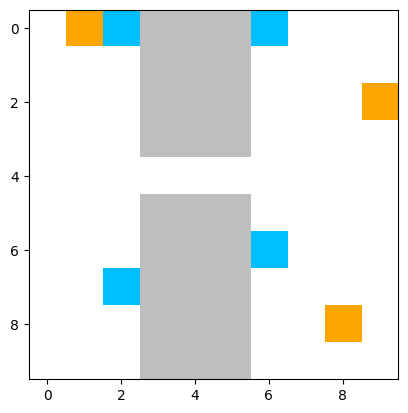

2024-06-18 14:41:39,223 - 20764 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed




> Entering new CrewAgentExecutor chain...


2024-06-18 14:41:45,492 - 20764 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed


Since my current position is (2,9) and my destination is (9,7), I need to move in a direction that brings me closer to my goal. Moving east is not an option as it is blocked by a wall. Going back south is not favourable as it will take me further away from my destination. Therefore, the best options are either to move north or west. Considering the coordinate system, moving west will decrease my x-coordinate which is not towards my destination as I need the x-coordinate to increase to reach (9,7). Thus, moving north seems to be the best choice.

Final Answer: North

> Finished chain.


> Entering new CrewAgentExecutor chain...


2024-06-18 14:41:49,712 - 20764 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed


Considering I am currently at coordinates (6,3) and my destination is (2,2), I need to move both south and west. However, my west is blocked so I cannot move in that direction. I just came from the south so I should try a different direction. To my east and north lies a path. Moving north will take me further away from my destination on the y-axis, so I will move east.

Final Answer: East

> Finished chain.


> Entering new CrewAgentExecutor chain...


KeyboardInterrupt: 

In [6]:
# 20 turn
for n in range(20):

  step = [0 for i in range(num_agents)]

  #각 에이전트들의 시야에 있는 자신과 다른 에이전트들
  FOV_agents = []
  for i in range(num_agents):
    if np.any(env.observe()[0][i][0][2:7, 2:7]):
      non_zero_elements = env.observe()[0][i][0][2:7, 2:7][env.observe()[0][i][0][2:7, 2:7] != 0].tolist()
      non_zero_elements = [element - 1 for element in non_zero_elements]
      non_zero_elements.append(i)
      FOV_agents.append(non_zero_elements)

  #알고리즘을 이용해 연결된 집합 찾기
  connected_sets = merge_sets(FOV_agents)

  #연결이 있는 모든 에이전트들
  deadlocked_agents = [item for sublist in connected_sets for item in sublist]

  for i in range(num_agents):

    #교착상태에 빠지지 않은 에이전트는 독립적으로 navigate
    if i not in deadlocked_agents:
      
      a_obs = env.observe()[0][i][1]
      x = env.observe()[1][i][1]
      y = map_width-env.observe()[1][i][0]
      x_finish = toy[2][i][1]
      y_finish = map_width-toy[2][i][0]

      if a_obs[4][3] == 0:
        west = """To your west lies a path."""
      else:
        west = """Your west is blocked by a wall."""

      if a_obs[4][5] == 0:
        east = """To your east lies a path."""
      else:
        east = """Your east is blocked by a wall."""

      if a_obs[5][4] == 0:
        south = """To your south lies a path."""
      else:
        south = """Your south is blocked by a wall."""

      if a_obs[3][4] == 0:
        north = """To your north lies a path."""
      else:
        north = """Your north is blocked by a wall."""

      if len(action_list[i]) == 0:
        last_action = """"""
      elif action_list[i][-1] in ['West', 'West.']:
        last_action = f"""You came from east."""
      elif action_list[i][-1] in ['East', 'East.']:
        last_action = f"""You came from west."""
      elif action_list[i][-1] in ['South', 'South.']:
        last_action = f"""You came from north."""
      elif action_list[i][-1] in ['North', 'North.']:
        last_action = f"""You came from south."""
      elif action_list[i][-1] in ['Stay', 'Stay.']:
        last_action = f"""You paused once for another agent or you reached your goal."""
      else:
        last_action = """"""

      navigation = tasks.path_finding(agents_set[i], x, y, x_finish, y_finish, east, west, north, south, last_action)

      crew = Crew(
        agents=[agents_set[i]],
        tasks=[navigation],
        verbose=0,
      )

      result = crew.kickoff()

      action_list[i].append(result)
    
      step[i] = directiondict[result]
  
  # 교착상태에 빠진 에이전트에 대해
  for connected_set in connected_sets:
    
    results = []

    for i in connected_set: # 여기서 i는 agent의 번호들
    
    #각각의 에이전트에 대해 원래 계획된 경로를 계산

      a_obs = env.observe()[0][i][1]
      x = env.observe()[1][i][1]
      y = map_width-env.observe()[1][i][0]
      x_finish = toy[2][i][1]
      y_finish = map_width-toy[2][i][0]

      if a_obs[4][3] == 0:
        west = """To your west lies a path."""
      else:
        west = """Your west is blocked by a wall."""

      if a_obs[4][5] == 0:
        east = """To your east lies a path."""
      else:
        east = """Your east is blocked by a wall."""

      if a_obs[5][4] == 0:
        south = """To your south lies a path."""
      else:
        south = """Your south is blocked by a wall."""

      if a_obs[3][4] == 0:
        north = """To your north lies a path."""
      else:
        north = """Your north is blocked by a wall."""

      if len(action_list[i]) == 0:
        last_action = """"""
      elif action_list[i][-1] in ['West', 'West.']:
        last_action = f"""You came from east."""
      elif action_list[i][-1] in ['East', 'East.']:
        last_action = f"""You came from west."""
      elif action_list[i][-1] in ['South', 'South.']:
        last_action = f"""You came from north."""
      elif action_list[i][-1] in ['North', 'North.']:
        last_action = f"""You came from south."""
      elif action_list[i][-1] in ['Stay', 'Stay.']:
        last_action = f"""You paused once for another agent or you reached your goal."""
      else:
        last_action = """"""

      navigation = tasks.path_finding(agents_set[i], x, y, x_finish, y_finish, east, west, north, south, last_action)

      crew = Crew(
        agents=[agents_set[i]],
        tasks=[navigation],
        verbose=0,
      )

      result = crew.kickoff()

      results.append(result)

    env_copy = copy.deepcopy(env)
    planned_step = [0 for _ in range(num_agents)]
    for idx, agent_idx in enumerate(connected_set):
      planned_step[agent_idx] = directiondict[results[idx]]
    if -0.5 in env_copy.step(planned_step)[1]:
      collision = True
    else:
      collision = False

    if not collision:
      for idx, agent_idx in enumerate(connected_set):
        action_list[agent_idx].append(results[idx])
        step[agent_idx] = directiondict[results[idx]]
# 충돌한다면 가장 큰 넘버의 에이전트가 우선권을 가지고, 나머지는 그를 피해가야 함 (이 부분을 좀더 정교화할 필요가 있음, 특히 3명 이상의 에이전트에 대한 경우. 일단 기본적으로는 얽힌 모든 에이전트가 가장 번호가 높은 에이전트에게서 도망가게.)
# 특히, 먼저 도착한 에이전트는 장애물이 되어 그 멈춘 에이전트를 발견한 다른 에이전트의 heuristic map이 업데이트되어야 함 (멈춘 에이전트로 인해 예상치 못한 deadend가 생김)
    else:
    # 먼저 prior agent는 원래대로 이동하게 함
      prior_agent_number = max(connected_set)
      prior_agent_idx = connected_set.index(prior_agent_number)
      action_list[prior_agent_number].append(results[prior_agent_idx])
      step[prior_agent_number] = directiondict[results[prior_agent_idx]]
      for i in connected_set:
        if i != prior_agent_number:
            a_obs = env.observe()[0][i][1]
            x = env.observe()[1][i][1]
            y = map_width-env.observe()[1][i][0]
            x_finish = toy[2][i][1]
            y_finish = map_width-toy[2][i][0]

            if a_obs[4][3] == 0:
                west = """To your west lies a path."""
            else:
                west = """Your west is blocked by a wall."""

            if a_obs[4][5] == 0:
                east = """To your east lies a path."""
            else:
                east = """Your east is blocked by a wall."""

            if a_obs[5][4] == 0:
                south = """To your south lies a path."""
            else:
                south = """Your south is blocked by a wall."""

            if a_obs[3][4] == 0:
                north = """To your north lies a path."""
            else:
                north = """Your north is blocked by a wall."""

            # prior agent의 direction 구하기
            agent_map = env.observe()[0][i][0][2:7, 2:7]
            center = (2, 2)
            max_position = np.unravel_index(np.argmax(agent_map), agent_map.shape)

            row_diff = center[0] - max_position[0]
            col_diff = center[1] - max_position[1]

            if row_diff > 0 and col_diff > 0:
                direction = "northwest"
            elif row_diff > 0 and col_diff == 0:
                direction = "north"
            elif row_diff > 0 and col_diff < 0:
                direction = "northeast"
            elif row_diff == 0 and col_diff > 0:
                direction = "west"
            elif row_diff == 0 and col_diff < 0:
                direction = "east"
            elif row_diff < 0 and col_diff > 0:
                direction = "southwest"
            elif row_diff < 0 and col_diff == 0:
                direction = "south"
            elif row_diff < 0 and col_diff < 0:
                direction = "southeast"
            else:
                direction = "center"

            give_way = tasks.give_way(agents_set[i], east, west, north, south, direction)

            crew = Crew(
                agents=[agents_set[i]],
                tasks=[give_way],
                verbose=0,
            )

            result = crew.kickoff()

            action_list[i] = []
    
            step[i] = directiondict[result]


  env.step(step)
  env.render()